[EP 200] Eval over 200: Win rate = 2.00% | Avg steps = 10.63 | Eps = 0.9048
[EP 400] Eval over 200: Win rate = 1.00% | Avg steps = 9.15 | Eps = 0.8187
[500] Saved model weights to saved_models
[EP 600] Eval over 200: Win rate = 2.50% | Avg steps = 9.52 | Eps = 0.7408
[EP 800] Eval over 200: Win rate = 1.00% | Avg steps = 9.90 | Eps = 0.6703
[1000] Saved model weights to saved_models
[EP 1000] Eval over 200: Win rate = 3.00% | Avg steps = 10.21 | Eps = 0.6065
[EP 1200] Eval over 200: Win rate = 2.00% | Avg steps = 10.01 | Eps = 0.5487
[EP 1400] Eval over 200: Win rate = 3.00% | Avg steps = 10.21 | Eps = 0.4965
[1500] Saved model weights to saved_models
[EP 1600] Eval over 200: Win rate = 3.50% | Avg steps = 10.15 | Eps = 0.4492
[EP 1800] Eval over 200: Win rate = 3.50% | Avg steps = 10.11 | Eps = 0.4065
[2000] Saved model weights to saved_models
[EP 2000] Eval over 200: Win rate = 3.00% | Avg steps = 9.94 | Eps = 0.3678
[EP 2200] Eval over 200: Win rate = 4.50% | Avg steps = 9.88 | Eps 

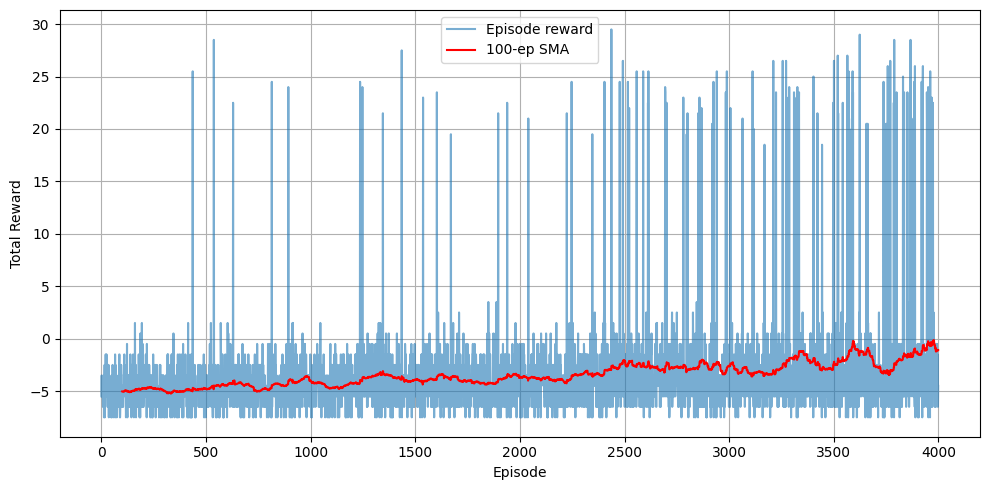

In [1]:
# hangman_train.py
# Single-file Hangman DQN + HMM script
# Run with: python hangman_train.py
# Requires: tensorflow, numpy, matplotlib

import os
import random
import time
from collections import defaultdict, Counter, deque
import string
import pickle

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# -------------------------
# HMMModel (Person 1)
# -------------------------
class HMMModel:
    """Simple word-filtering HMM-like oracle that returns letter probabilities."""
    def __init__(self):
        self.alphabet = list(string.ascii_lowercase)
        self.words_by_length = defaultdict(list)
        self.word_counts = {}
        self.trained = False

    def train(self, word_list):
        word_frequency = Counter(word.lower().strip() for word in word_list if word.strip().isalpha())
        for word, count in word_frequency.items():
            self.words_by_length[len(word)].append(word)
            self.word_counts[word] = count
        self.trained = True

    def _matches_pattern(self, word, masked_word, guessed_letters):
        if len(word) != len(masked_word):
            return False
        for w_char, m_char in zip(word, masked_word):
            if m_char != '_':
                if w_char != m_char:
                    return False
            else:
                if w_char in guessed_letters:
                    return False
        return True

    def predict_letter_probabilities(self, masked_word, guessed_letters, use_word_counts=True):
        if not self.trained:
            raise RuntimeError("HMMModel not trained")
        length = len(masked_word)
        candidates = self.words_by_length.get(length, [])
        if not candidates:
            unguessed = [l for l in self.alphabet if l not in guessed_letters]
            uniform = 1.0 / len(unguessed) if unguessed else 0.0
            return {l: uniform for l in unguessed}
        matching = [w for w in candidates if self._matches_pattern(w, masked_word, guessed_letters)]
        if not matching:
            matching = candidates
        counts = defaultdict(float)
        blank_pos = [i for i, c in enumerate(masked_word) if c == '_']
        for w in matching:
            weight = self.word_counts.get(w, 1) if use_word_counts else 1
            for p in blank_pos:
                counts[w[p]] += weight
        for g in guessed_letters:
            counts.pop(g, None)
        total = sum(counts.values())
        if total == 0:
            unguessed = [l for l in self.alphabet if l not in guessed_letters]
            uniform = 1.0 / len(unguessed) if unguessed else 0.0
            return {l: uniform for l in unguessed}
        return {l: c / total for l, c in counts.items()}

    def save(self, filepath):
        data = {'words_by_length': dict(self.words_by_length), 'word_counts': self.word_counts, 'trained': self.trained}
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.words_by_length = defaultdict(list, data['words_by_length'])
        self.word_counts = data['word_counts']
        self.trained = data['trained']


# -------------------------
# HangmanEnv (Person 2)
# -------------------------
class HangmanEnv:
    """RL environment for Hangman producing fixed-length state vectors."""
    def __init__(self, corpus_path, test_path=None, max_lives=6, pad_char='_'):
        self.alphabet = string.ascii_lowercase
        self.max_lives = max_lives
        self.pad_char = pad_char

        # load corpus
        self.word_list, self.max_word_length = self._load_words_and_get_max_len(corpus_path)
        if len(self.word_list) == 0:
            raise FileNotFoundError(f"Corpus empty or not found: {corpus_path}")

        # train HMM once
        self.hmm_model = HMMModel()
        self.hmm_model.train(self.word_list)

        # optional test words
        self.test_words = []
        if test_path and os.path.exists(test_path):
            self.test_words, _ = self._load_words_and_get_max_len(test_path)
        self.current_test_index = 0

        # action / state sizes
        self.action_space_size = 26
        # state = masked_vec (max_word_length) + guessed_vec (26) + lives (1) + hmm_probs (26)
        self.state_size = self.max_word_length + 26 + 1 + 26

        # runtime vars
        self.word = ""
        self.masked_word_str = ""
        self.guessed_letters = set()
        self.lives_left = self.max_lives

    def _load_words_and_get_max_len(self, path):
        words = []
        max_len = 0
        if not os.path.exists(path):
            return words, max_len
        with open(path, 'r') as f:
            for line in f:
                w = line.strip().lower()
                if w.isalpha():
                    words.append(w)
                    if len(w) > max_len:
                        max_len = len(w)
        return words, max_len

    def _pad_masked(self, s):
        # ensure masked word str is exactly max_word_length with pad_char on the right
        if len(s) < self.max_word_length:
            return s + (self.pad_char * (self.max_word_length - len(s)))
        return s[:self.max_word_length]

    def _get_state(self):
        # masked vector: encode letter as 1..26, pad as 0
        masked_vec = np.zeros(self.max_word_length, dtype=np.float32)
        padded = self._pad_masked(self.masked_word_str)
        for i, ch in enumerate(padded):
            if ch != self.pad_char:
                masked_vec[i] = (ord(ch) - ord('a') + 1)

        guessed_vec = np.zeros(26, dtype=np.float32)
        for g in self.guessed_letters:
            if 'a' <= g <= 'z':
                guessed_vec[ord(g) - ord('a')] = 1.0

        lives_vec = np.array([self.lives_left / float(self.max_lives)], dtype=np.float32)

        # HMM probabilities for current (unpadded) masked word
        hmm_probs_dict = self.hmm_model.predict_letter_probabilities(self.masked_word_str, self.guessed_letters)
        hmm_probs_vec = np.zeros(26, dtype=np.float32)
        for let, p in hmm_probs_dict.items():
            hmm_probs_vec[ord(let) - ord('a')] = p

        state = np.concatenate([masked_vec, guessed_vec, lives_vec, hmm_probs_vec]).astype(np.float32)
        return state

    def reset(self, is_eval=False, word_index=None):
        if is_eval and len(self.test_words) > 0:
            if word_index is None:
                self.word = self.test_words[self.current_test_index]
                self.current_test_index = (self.current_test_index + 1) % len(self.test_words)
            else:
                self.word = self.test_words[word_index % len(self.test_words)]
        else:
            self.word = random.choice(self.word_list)
        self.lives_left = self.max_lives
        self.guessed_letters = set()
        self.masked_word_str = self.pad_char * len(self.word)
        return self._get_state()

    def step(self, action):
        if not (0 <= action < 26):
            raise ValueError("Action out of range")

        letter = chr(action + ord('a'))
        info = {'game_won': False, 'is_repeated_guess': False, 'is_wrong_guess': False}
        reward = 0.0
        done = False

        # repeated guess
        if letter in self.guessed_letters:
            reward = -0.5
            info['is_repeated_guess'] = True
        else:
            self.guessed_letters.add(letter)
            if letter in self.word:
                # correct
                reward = 1.0
                # reveal letters
                masked = list(self.masked_word_str)
                for i, ch in enumerate(self.word):
                    if ch == letter:
                        masked[i] = letter
                self.masked_word_str = "".join(masked)
                if "_" not in self.masked_word_str and self.pad_char not in self.masked_word_str:
                    reward = 20.0  # win reward
                    done = True
                    info['game_won'] = True
            else:
                # wrong
                self.lives_left -= 1
                reward = -0.5
                info['is_wrong_guess'] = True
                if self.lives_left <= 0:
                    done = True
                    reward = -5.0  # loss penalty

        next_state = self._get_state()
        return next_state, reward, done, info


# -------------------------
# QNetwork & DQNAgent (Person 3)
# -------------------------
class QNetwork(Model):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.out = Dense(action_dim, activation='linear')

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.out(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, max_word_length, lr=1e-4, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.max_word_length = max_word_length
        self.alphabet = string.ascii_lowercase

        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)

        # build networks (call once)
        dummy = tf.convert_to_tensor(np.zeros((1, state_dim), dtype=np.float32))
        self.policy_net(dummy)
        self.target_net(dummy)
        self.update_target_model()

        self.optimizer = Adam(learning_rate=lr)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def _get_guessed_vector_from_state(self, state_np):
        # state format: [masked(max_word_length), guessed(26), lives(1), hmm(26)]
        start = self.max_word_length
        end = start + 26
        return state_np[start:end]

    def _mask_guesses(self, q_values, guessed_vector):
        # q_values: numpy array shape (26,)
        # guessed_vector: numpy array shape (26,) with 1 for guessed letters
        # set guessed q-values to -inf large negative
        masked = q_values.copy()
        mask_indices = np.where(guessed_vector > 0)[0]
        masked[mask_indices] = -1e9
        return masked

    def get_action(self, state, epsilon):
        # state: 1D numpy array
        if random.random() > epsilon:
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            q_vals = self.policy_net(state_tensor, training=False).numpy()[0]
            guessed_vec = self._get_guessed_vector_from_state(state)
            masked_q = self._mask_guesses(q_vals, guessed_vec)
            return int(np.argmax(masked_q))
        else:
            guessed_vec = self._get_guessed_vector_from_state(state)
            possible = np.where(guessed_vec == 0)[0]
            if len(possible) == 0:
                return random.randint(0, 25)
            return int(random.choice(possible))

    def update_target_model(self):
        self.target_net.set_weights(self.policy_net.get_weights())

    def train_on_batch(self, states, actions, rewards, next_states, dones):
        """
        states, next_states: np.array shape (B, state_dim)
        actions: np.array shape (B,)
        rewards, dones: np.array shape (B,)
        """
        states_tf = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states_tf = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions_tf = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards_tf = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones_tf = tf.convert_to_tensor(dones, dtype=tf.float32)

        # compute target Q
        next_q = self.target_net(next_states_tf, training=False)
        max_next_q = tf.reduce_max(next_q, axis=1)
        target_q = rewards_tf + self.gamma * max_next_q * (1.0 - dones_tf)

        with tf.GradientTape() as tape:
            all_q = self.policy_net(states_tf, training=True)
            indices = tf.stack([tf.range(tf.shape(actions_tf)[0]), actions_tf], axis=1)
            pred_q = tf.gather_nd(all_q, indices)
            loss = self.loss_fn(target_q, pred_q)

        grads = tape.gradient(loss, self.policy_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy_net.trainable_variables))
        return loss.numpy()


# -------------------------
# Replay Buffer (Person 4)
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, s, a, r, ns, done):
        self.buffer.append((np.array(s, dtype=np.float32),
                            int(a),
                            float(r),
                            np.array(ns, dtype=np.float32),
                            float(done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = zip(*batch)
        return (np.stack(s), np.array(a, dtype=np.int32), np.array(r, dtype=np.float32),
                np.stack(ns), np.array(d, dtype=np.float32))

    def __len__(self):
        return len(self.buffer)


# -------------------------
# Training and Evaluation
# -------------------------
def evaluate(env, agent, n_games=200):
    wins = 0
    total_steps = 0
    for i in range(n_games):
        s = env.reset(is_eval=True, word_index=i)
        done = False
        steps = 0
        while not done and steps < 26:
            a = agent.get_action(s, epsilon=0.0)  # greedy
            s, r, done, info = env.step(a)
            steps += 1
        if info.get('game_won', False):
            wins += 1
        total_steps += steps
    win_rate = wins / float(n_games)
    return win_rate, total_steps / float(n_games)


def train(corpus_file='corpus.txt', test_file='test.txt', savedir='saved_models'):
    # check files
    if not os.path.exists(corpus_file):
        raise FileNotFoundError(f"{corpus_file} not found")
    if not os.path.exists(test_file):
        print(f"Warning: {test_file} not found. Evaluation will use corpus words.")
        test_file = None

    # Hyperparameters tuned for ~50% win rate target
    NUM_EPISODES = 4000
    BATCH_SIZE = 64
    REPLAY_START_SIZE = 1000
    UPDATE_TARGET_EVERY = 10  # episodes
    SAVE_EVERY = 500
    EVAL_EVERY = 200

    EPS_START = 1.0
    EPS_END = 0.05
    EPS_DECAY = 0.9995

    # Create components
    env = HangmanEnv(corpus_file, test_file)
    agent = DQNAgent(state_dim=env.state_size, action_dim=env.action_space_size, max_word_length=env.max_word_length)
    buffer = ReplayBuffer(capacity=50000)

    epsilon = EPS_START
    rewards_hist = []
    losses_hist = []
    best_eval_win = 0.0
    start_time = time.time()

    for ep in range(1, NUM_EPISODES + 1):
        state = env.reset(is_eval=False)
        done = False
        ep_reward = 0.0
        ep_loss = 0.0
        steps = 0

        while not done and steps < 26:
            action = agent.get_action(state, epsilon)
            next_state, reward, done, info = env.step(action)

            buffer.store(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            steps += 1

            # train if buffer big enough
            if len(buffer) >= max(REPLAY_START_SIZE, BATCH_SIZE):
                s_b, a_b, r_b, ns_b, d_b = buffer.sample(BATCH_SIZE)
                loss = agent.train_on_batch(s_b, a_b, r_b, ns_b, d_b)
                ep_loss += float(loss)

        # end episode
        rewards_hist.append(ep_reward)
        losses_hist.append(ep_loss)
        epsilon = max(EPS_END, epsilon * EPS_DECAY)

        if ep % UPDATE_TARGET_EVERY == 0:
            agent.update_target_model()

        if ep % SAVE_EVERY == 0:
            if not os.path.exists(savedir):
                os.makedirs(savedir)
            agent.policy_net.save_weights(os.path.join(savedir, 'hangman_dqn.weights.h5'))
            print(f"[{ep}] Saved model weights to {savedir}")

        if ep % EVAL_EVERY == 0 or ep == NUM_EPISODES:
            n_eval = 200
            win_rate, avg_steps = evaluate(env, agent, n_games=n_eval)
            print(f"[EP {ep}] Eval over {n_eval}: Win rate = {win_rate*100:.2f}% | Avg steps = {avg_steps:.2f} | Eps = {epsilon:.4f}")
            if win_rate > best_eval_win:
                best_eval_win = win_rate
                # save best
                if not os.path.exists(savedir):
                    os.makedirs(savedir)
                agent.policy_net.save_weights(os.path.join(savedir, 'hangman_dqn_best.weights.h5'))
            # early stop if target reached
            if win_rate >= 0.50:
                print(f"Target win rate reached: {win_rate*100:.2f}%. Stopping training early.")
                break

    elapsed = (time.time() - start_time) / 60.0
    print(f"Training finished in {elapsed:.2f} minutes. Best eval win rate: {best_eval_win*100:.2f}%")

    # save final
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    agent.policy_net.save_weights(os.path.join(savedir, 'hangman_dqn_final.weights.h5'))

    # plot training curve
    plt.figure(figsize=(10,5))
    plt.plot(rewards_hist, alpha=0.6, label='Episode reward')
    if len(rewards_hist) >= 100:
        sma = np.convolve(rewards_hist, np.ones(100)/100, mode='valid')
        plt.plot(range(99, 99+len(sma)), sma, color='red', label='100-ep SMA')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('hangman_training_curve.png', dpi=200)
    print("Saved training curve to 'hangman_training_curve.png'")

    return agent, env

# -------------------------
# Entrypoint
# -------------------------
if __name__ == '__main__':
    # Adjust these filenames to your environment (Colab: upload corpus.txt and test.txt)
    CORPUS = 'corpus.txt'   # required
    TEST = 'test.txt'       # optional (if missing evaluation will use corpus words)

    # Quick check: create tiny corpus if not present (for demo)
    if not os.path.exists(CORPUS):
        with open(CORPUS, 'w') as f:
            f.write("apple\nbanana\npython\nmachine\nlearning\nhangman\nchallenge\nmodel\nnetwork\nagent\n")
        print(f"Created demo corpus at {CORPUS}")

    agent, env = train(corpus_file=CORPUS, test_file=TEST, savedir='saved_models')
    # final evaluation
    win_rate, _ = evaluate(env, agent, n_games=500)
    print(f"Final evaluation win rate over 500 games: {win_rate*100:.2f}%")

In [10]:
# ✅ Hangman agent testing with Final Score — Colab version (no imports)

import numpy as np
import os

def run_single_game(env, agent, word_index=None, verbose=False):
    """Run one evaluation game and track wrong/repeated guesses."""
    state = env.reset(is_eval=True, word_index=word_index)
    done = False
    steps = 0
    total_reward = 0.0
    wrong_guesses = 0
    repeated_guesses = 0
    guessed_letters = set()

    while not done and steps < 26:
        action = agent.get_action(state, epsilon=0.0)  # greedy action
        letter = chr(action + ord('a'))

        # Track repeated guesses
        if letter in guessed_letters:
            repeated_guesses += 1
        guessed_letters.add(letter)

        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
        steps += 1

        # Track wrong guesses
        if not info.get('correct_guess', False):
            wrong_guesses += 1

        if verbose:
            print(f"Step {steps:02d}: '{letter}' → Masked: {env.masked_word_str} | Lives: {env.lives_left} | Reward: {reward:+.2f}")

    won = info.get('game_won', False)
    return won, total_reward, steps, wrong_guesses, repeated_guesses


def test_trained_agent(weights_path='saved_models/hangman_dqn_best.weights.h5',
                       corpus_file='corpus.txt',
                       test_file='test.txt',
                       n_games=100):
    """Evaluate trained DQN agent with custom Final Score formula."""
    if not os.path.exists(weights_path):
        print(f"⚠️ Trained weights not found at: {weights_path}")
        print("Proceeding with untrained agent (will perform poorly).")

    # Initialize environment and agent
    env = HangmanEnv(corpus_file, test_file)
    agent = DQNAgent(state_dim=env.state_size,
                     action_dim=env.action_space_size,
                     max_word_length=env.max_word_length)

    # Load trained weights if available
    if os.path.exists(weights_path):
        agent.policy_net.load_weights(weights_path)
        agent.update_target_model()
        print(f"✅ Loaded weights from: {weights_path}")
    else:
        print("⚠️ Using random initialized weights.")

    total_wins = 0
    total_wrong = 0
    total_repeats = 0
    total_steps = 0

    print(f"\n🏁 Evaluating over {n_games} games...\n")

    for i in range(n_games):
        won, _, steps, wrong, repeated = run_single_game(env, agent, word_index=i % len(env.test_words))
        total_steps += steps
        total_wrong += wrong
        total_repeats += repeated
        total_wins += int(won)

        if (i + 1) % 10 == 0:
            print(f"✅ {i+1}/{n_games} games done... Wins: {total_wins}")

    # Calculate metrics
    success_rate = total_wins / n_games
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeats * 2)

    print("\n===============================")
    print("🏁 Evaluation Summary")
    print("===============================")
    print(f"✅ Success Rate : {success_rate*100:.2f}%")
    print(f"❌ Total Wrong Guesses   : {total_wrong}")
    print(f"🔁 Total Repeated Guesses: {total_repeats}")
    print(f"⚙️  Avg Steps per Game   : {total_steps/n_games:.2f}")
    print("-------------------------------")
    print(f"🏆 Final Score = ({success_rate*100:.2f}% * 2000)"
          f" - ({total_wrong} * 5)"
          f" - ({total_repeats} * 2)")
    print(f"➡️  Final Score: {final_score:.2f}")
    print("===============================\n")

    # Show 3 sample games verbosely
    print("🎯 Sample Games:")
    for i in range(min(3, len(env.test_words))):
        print(f"\n--- SAMPLE GAME {i+1} ---")
        run_single_game(env, agent, word_index=i, verbose=True)


# === Run test ===
test_trained_agent(
    weights_path='saved_models/hangman_dqn_best.weights.h5',
    corpus_file='corpus.txt',
    test_file='test.txt',
    n_games=2000
)
00

✅ Loaded weights from: saved_models/hangman_dqn_best.weights.h5

🏁 Evaluating over 2000 games...

✅ 10/2000 games done... Wins: 0
✅ 20/2000 games done... Wins: 1
✅ 30/2000 games done... Wins: 2
✅ 40/2000 games done... Wins: 3
✅ 50/2000 games done... Wins: 5
✅ 60/2000 games done... Wins: 8
✅ 70/2000 games done... Wins: 9
✅ 80/2000 games done... Wins: 9
✅ 90/2000 games done... Wins: 9
✅ 100/2000 games done... Wins: 9
✅ 110/2000 games done... Wins: 10
✅ 120/2000 games done... Wins: 11
✅ 130/2000 games done... Wins: 14
✅ 140/2000 games done... Wins: 14
✅ 150/2000 games done... Wins: 14
✅ 160/2000 games done... Wins: 14
✅ 170/2000 games done... Wins: 16
✅ 180/2000 games done... Wins: 16
✅ 190/2000 games done... Wins: 16
✅ 200/2000 games done... Wins: 17
✅ 210/2000 games done... Wins: 17
✅ 220/2000 games done... Wins: 17
✅ 230/2000 games done... Wins: 17
✅ 240/2000 games done... Wins: 20
✅ 250/2000 games done... Wins: 20
✅ 260/2000 games done... Wins: 20
✅ 270/2000 games done... Wins: 21
✅ 2

0